<a href="https://colab.research.google.com/github/mohitraosatya/rei-quantum-uc/blob/main/REI_QU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install qiskit qiskit-optimization --quiet
!pip install qiskit-optimization[cplex] --quiet
!pip install qiskit-optimization[gurobi] --quiet
!pip install qiskit-optimization[dwave] --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 70.3 MB/s eta 0:00:00


In [37]:
pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 58.8 MB/s eta 0:00:00


In [68]:
!pip install qiskit-utils

In [92]:
import numpy as np
from qiskit_aer import Aer
from qiskit.primitives import Sampler
from qiskit_algorithms import QAOA
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms.optimizers import COBYLA


# For visualization
import matplotlib.pyplot as plt



In [70]:
# Problem parameters
demand = 50
costs = np.array([40, 25, 55])
capacities = np.array([30, 20, 40])
A = 100  # Penalty coefficient

num_generators = len(costs)
print(f"Number of generators: {num_generators}")
print(f"Demand: {demand} MW")
print("Generator details:")
for i in range(num_generators):
    print(f"  Generator {i+1}: {capacities[i]} MW, cost = {costs[i]}")

Number of generators: 3
Demand: 50 MW
Generator details:
  Generator 1: 30 MW, cost = 40
  Generator 2: 20 MW, cost = 25
  Generator 3: 40 MW, cost = 55


In [71]:
# Initialize QUBO coefficients
linear = {}
quadratic = {}

for i in range(num_generators):
    # Compute linear coefficient for x_i
    linear[i] = costs[i] - 2 * A * demand * capacities[i] + A * (capacities[i] ** 2)

for i in range(num_generators):
    for j in range(i+1, num_generators):
        quadratic[(i, j)] = 2 * A * capacities[i] * capacities[j]

print("Linear coefficients (Q_ii):")
for i in range(num_generators):
    print(f"  Q[{i},{i}] = {linear[i]}")

print("\nQuadratic coefficients (Q_ij) for i<j:")
for key, value in quadratic.items():
    print(f"  Q{key} = {value}")

Linear coefficients (Q_ii):
  Q[0,0] = -209960
  Q[1,1] = -159975
  Q[2,2] = -239945

Quadratic coefficients (Q_ij) for i<j:
  Q(0, 1) = 120000
  Q(0, 2) = 240000
  Q(1, 2) = 160000


In [72]:
# Create a QuadraticProgram instance
qp = QuadraticProgram("Unit_Commitment")

# Add binary variables for each generator
for i in range(num_generators):
    qp.binary_var(name=f"x{i}")

# Set up the objective: minimize the QUBO function.
# Note: Qiskit's QuadraticProgram minimizes a quadratic function of the form:
#   f(x) = sum_i c_i x_i + sum_{i<j} Q_ij x_i x_j
# We add the linear and quadratic terms computed earlier.
qp.minimize(linear=linear, quadratic=quadratic)

# (Optional) Print the problem formulation
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Unit_Commitment

Minimize
 obj: - 209960 x0 - 159975 x1 - 239945 x2 + [ 240000 x0*x1 + 480000 x0*x2
      + 320000 x1*x2 ]/2
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1

Binaries
 x0 x1 x2
End



In [73]:
# Use the classical optimizer to solve the problem (brute-force for small problems)
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.algorithms import CplexOptimizer

try:
    classical_optimizer = CplexOptimizer()
    classical_result = classical_optimizer.solve(qp)
    print("Classical optimizer result:")
    print(classical_result)
except Exception as e:
    # If CPLEX is not available, fall back to a built-in exact solver (for very small problems)
    print("CplexOptimizer not available; using exact solver instead.")
    from qiskit_optimization.algorithms import MinimumEigenOptimizer
    from qiskit_algorithms import NumPyMinimumEigensolver

    exact_solver = MinimumEigenOptimizer(NumPyMinimumEigensolver())
    classical_result = exact_solver.solve(qp)
    print(classical_result)


CplexOptimizer not available; using exact solver instead.
fval=-249935.0, x0=1.0, x1=1.0, x2=0.0, status=SUCCESS


In [111]:
# Cell 7: Set Up QAOA to Solve the Problem Quantum–Mechanically

from qiskit_aer import AerSimulator

# Create the simulator backend directly
quantum_instance = AerSimulator()

# Set up the COBYLA optimizer (you can tweak maxiter for more precision)
from qiskit_algorithms.optimizers import COBYLA
sampler = Sampler()
optimizer = COBYLA(maxiter=250)

# Set up QAOA with a small depth (reps=1) for demonstration purposes
from qiskit_algorithms import QAOA
qaoa = QAOA(optimizer=optimizer, reps=1, sampler=sampler)

# Set the backend directly on the QAOA instance
qaoa.backend = quantum_instance

# Wrap QAOA in the MinimumEigenOptimizer to solve our optimization problem
from qiskit_optimization.algorithms import MinimumEigenOptimizer
qaoa_optimizer = MinimumEigenOptimizer(qaoa)

print("QAOA has been set up successfully!")


QAOA has been set up successfully!


<ipython-input-111-188e76285cdf>:10: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


In [112]:
# Cell 8: Solve the QUBO Using QAOA and Display the Results

# Solve the problem using QAOA via the MinimumEigenOptimizer
qaoa_result = qaoa_optimizer.solve(qp)
print("QAOA optimizer result:")
print(qaoa_result)

# Interpret the solution: the decision vector indicates which generators are 'on'
solution = qaoa_result.x
selected_generators = [i+1 for i, val in enumerate(solution) if round(val) == 1]
print("\nSelected Generators (by index):", selected_generators)

# Calculate total capacity and cost based on the selected generators
total_capacity = sum(capacities[i] for i, val in enumerate(solution) if round(val) == 1)
total_cost = sum(costs[i] for i, val in enumerate(solution) if round(val) == 1)

print(f"\nTotal capacity: {total_capacity} MW (Demand = {demand} MW)")
print(f"Total cost: ${total_cost}")



QAOA optimizer result:
fval=-249935.0, x0=1.0, x1=1.0, x2=0.0, status=SUCCESS

Selected Generators (by index): [1, 2]

Total capacity: 50 MW (Demand = 50 MW)
Total cost: $65


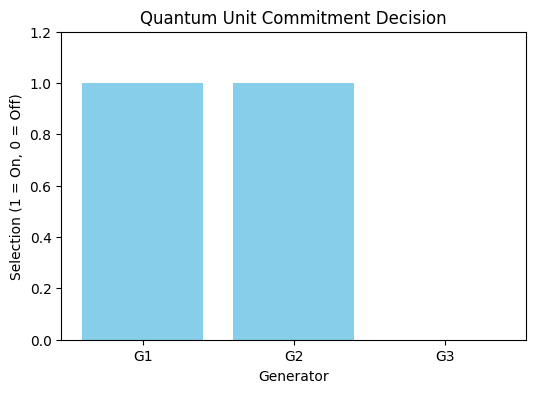

In [113]:
# Plot a bar chart of the generator selection
plt.figure(figsize=(6,4))
plt.bar(range(1, num_generators+1), solution, tick_label=[f"G{i+1}" for i in range(num_generators)], color='skyblue')
plt.xlabel("Generator")
plt.ylabel("Selection (1 = On, 0 = Off)")
plt.title("Quantum Unit Commitment Decision")
plt.ylim(0, 1.2)
plt.show()
